In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random

In [57]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other): #value + value
        other = other if (isinstance(other, Value)) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data)**(other - 1) * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if (isinstance(other, Value)) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other): #allows __mul__ to be commutative, ie self * other (now that rmul is defined) equals other * self
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward

        return out
    def __truediv__(self, other): #self / other
        return self * other**(-1)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [58]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR means left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular (or 'record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is the result of some operation, create an op node for it
            dot.node(name =uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

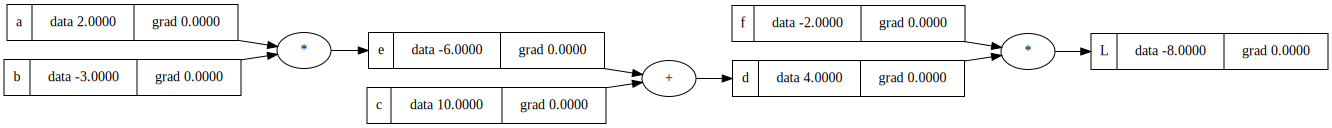

In [59]:
draw_dot(L)

In [60]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-8.0


In [61]:
#all grad values are with respect to L. how does a nudge in input affect L?
L.grad = 1 #definition)

d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1
c.grad = d.grad * 1
b.grad = d.grad * 1 * a.data
a.grad = d.grad * 1 * b.data


In [62]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

0.0


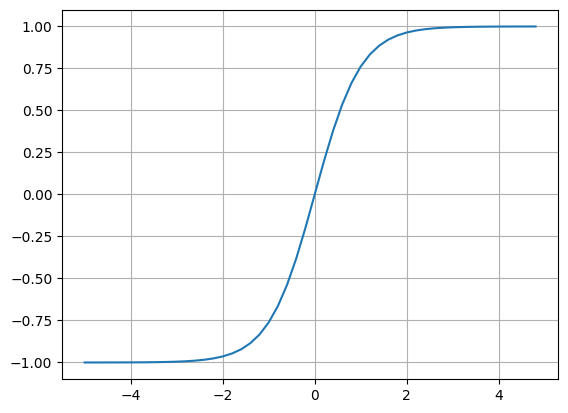

In [63]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [64]:
#xs are inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#w is weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#b is bias of neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

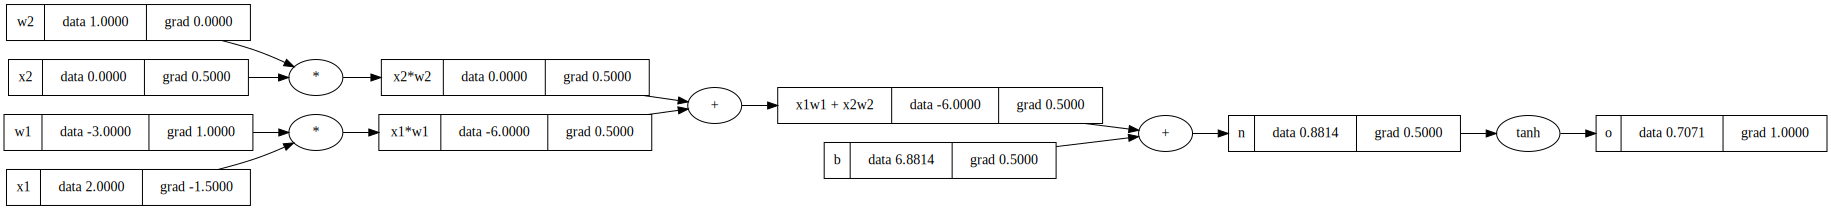

In [65]:
draw_dot(o)

In [66]:
o.backward()

In [67]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [68]:
o.grad = 1.0

In [69]:
o._backward()

In [70]:
n._backward()

In [71]:
b._backward()

In [72]:
x1w1x2w2._backward()

In [73]:
x1w1._backward()

In [74]:
x2w2._backward()

In [75]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [76]:
1 - o.data**2

0.4999999999999999

In [77]:
#o = tanh(n)
# do/dn = 1 - tanh^2(n) = 1 - o^2

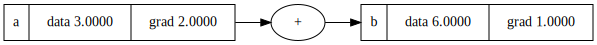

In [78]:
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

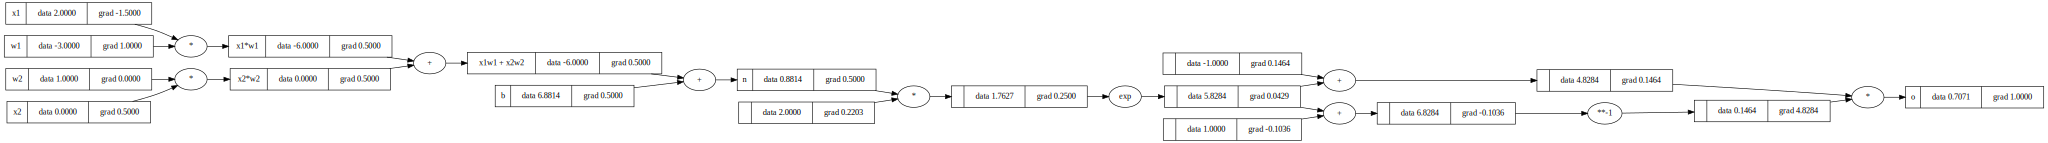

In [79]:
#xs are inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#w is weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#b is bias of neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1); 
o.label = 'o'
o.backward()
draw_dot(o)

In [80]:
import torch
import random

In [81]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


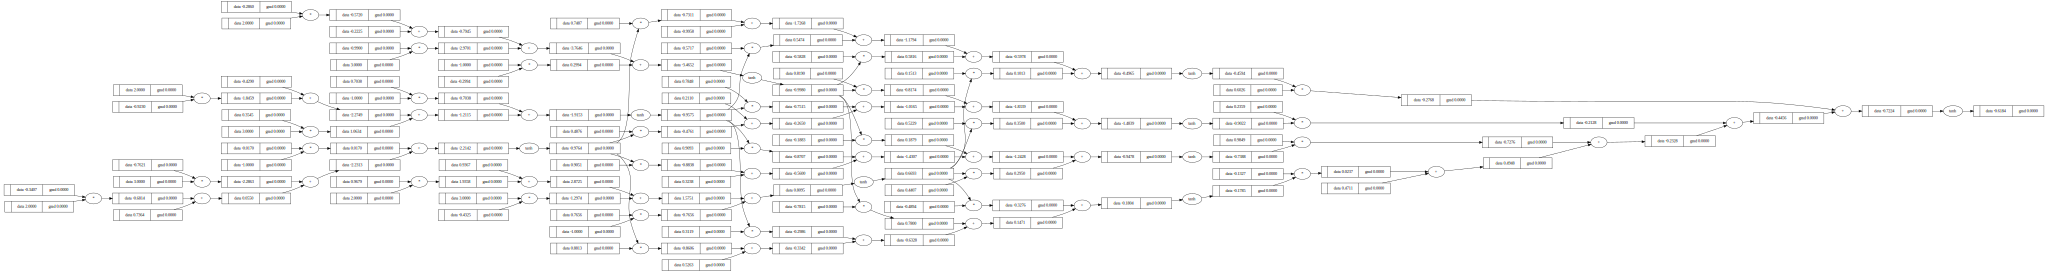

In [82]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #w for weight
        self.b = Value(random.uniform(-1,1)) #b for bias

    def __call__(self, x):
    #w dotproduct x plus b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout): #nin is num inputs for each neuron. nout is the number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
       # return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [83]:
type(n)

__main__.MLP

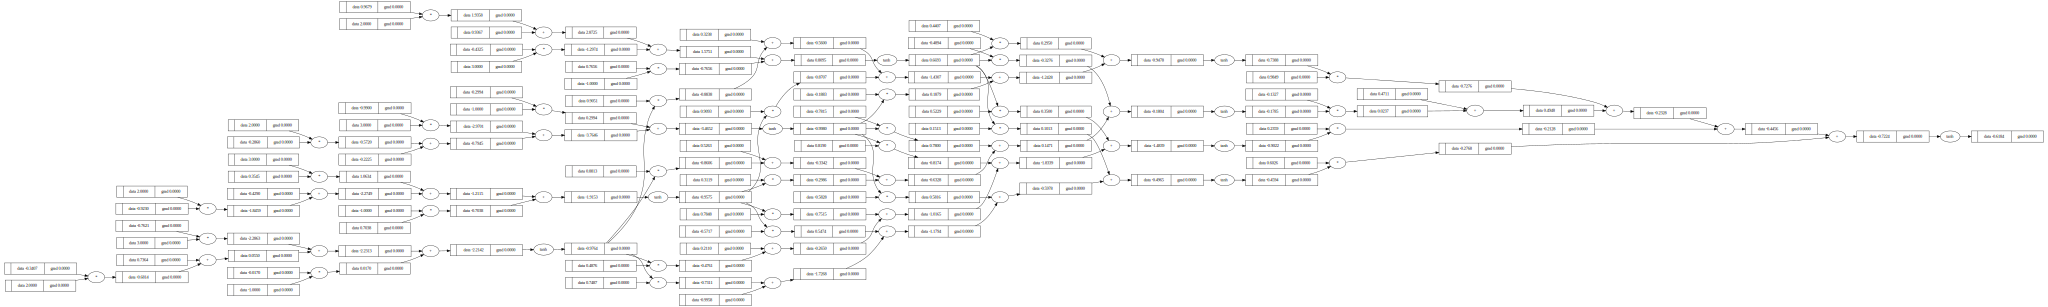

In [84]:
draw_dot(n(x))

In [ ]:
#toy example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.7, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [0.9, -0.69, -0.69, 1.0] ##desirable outputs for each respective input from x
ypred = [n(x) for x in xs]


In [ ]:

for j in range(1580):
    #forward pass    
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update (take step / descend)
    for p in n.parameters():
        p.data += -0.01 * p.grad
    if j % 50 == 0:
        print (j, loss.data)

In [58]:
ypred

[Value(data=0.9533472341222147),
 Value(data=-0.7064106715621449),
 Value(data=-0.6739046094018145),
 Value(data=0.9439125300675992)]

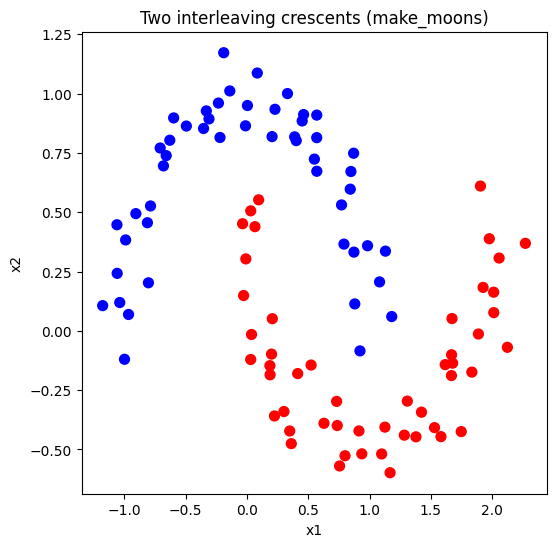

In [86]:
#OUR DATASET WILL BE THESE DOTS! binary classification based on color
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

xs, y = make_moons(n_samples=100, noise=0.1, random_state=42)

plt.figure(figsize=(6,6))
plt.scatter(xs[:,0], xs[:,1], c=y, cmap='bwr', s=50)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Two interleaving crescents (make_moons)')
plt.show()


In [87]:
print(y)

[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [ ]:
moonMLP = MLP(2, [10, 10, 1])

#because we are using tanh, whose range is from -1 to 1, change the membership identifiers from 0 and 1 to instead be -1 and 1
ys = [-1 if yi == 0 else 1 for yi in y] #desired targets

for j in range(1500):

    ypred = [moonMLP(x) for x in xs]
    #ypred
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in moonMLP.parameters():
        p.grad = 0
    loss.backward()

#update (take step / descend)
    for p in moonMLP.parameters():
        p.data += -0.01 * p.grad
    if j % 50 == 0:
        print (j, loss.data)

0 144.6066925001247


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7bf21a38a270>>
Traceback (most recent call last):
  File "/home/azky/jlab/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


50 3.8322724634568326
100 0.4197500744481227
150 0.22814749252087566
200 0.1516668528179812
250 0.11168424390736939
300 0.08748862326325053
350 0.07142858038263349
400 0.060066268626007696
450 0.05164311068565021
500 0.04517198236939706
550 0.04005861163300445
600 0.03592509848698571
650 0.03252031619964697
700 0.02967122993616303
750 0.027254944136021954
800 0.02518189753781638


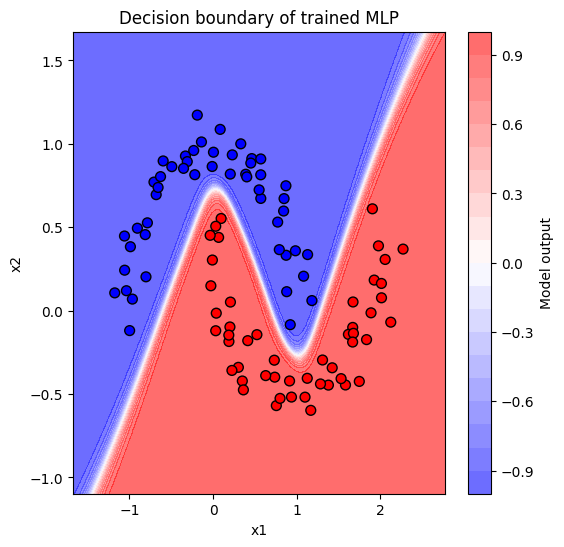

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# define a grid of points covering the data range
x_min, x_max = xs[:,0].min() - 0.5, xs[:,0].max() + 0.5
y_min, y_max = xs[:,1].min() - 0.5, xs[:,1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# flatten the grid so we can feed it through the network
grid_points = np.c_[xx.ravel(), yy.ravel()]

# evaluate the model on each point
zz = [moonMLP(p).data for p in grid_points]   # assuming moonMLP(x) returns a Value
zz = np.array(zz).reshape(xx.shape)

# plot decision boundary and data
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, zz, levels=20, cmap="bwr", alpha=0.6)
plt.colorbar(label='Model output')

# original points
plt.scatter(xs[:,0], xs[:,1], c=y, cmap='bwr', edgecolor='k', s=50)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Decision boundary of trained MLP")
plt.show()


In [5]:
from sklearn.datasets import make_circles

Text(0.5, 1.0, 'make_circles')

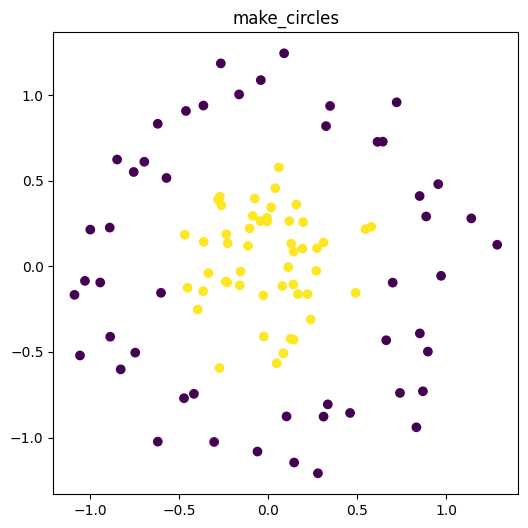

In [12]:
fig, ax1 = plt.subplots(figsize=(6, 6))
X, Y = make_circles(noise=0.15, factor=0.3, random_state=5)
ax1.scatter(X[:, 0], X[:, 1], c=Y)
ax1.set_title("make_circles")

In [13]:
ys = [-1 if yi == 0 else 1 for yi in Y]

In [12]:
ys

[-1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1]

In [93]:
X

array([[-7.15131380e-01,  5.01375478e-01],
       [ 3.94304557e-01,  9.68455425e-01],
       [ 2.38975156e-01, -1.51187001e-01],
       [-7.15949446e-01,  9.35912483e-01],
       [-4.22803344e-03,  2.83037288e-01],
       [-8.90832061e-01,  2.78478596e-01],
       [ 3.58200593e-01,  1.37707764e-01],
       [ 2.62152631e-01, -3.49242320e-01],
       [ 5.35077671e-01, -9.55647599e-01],
       [ 6.07481593e-01, -2.54661022e-01],
       [ 6.38090099e-01, -6.60554395e-01],
       [ 9.56582725e-01,  4.99773487e-01],
       [ 2.41099218e-01, -1.97483175e-01],
       [-1.05831948e+00, -2.48091716e-01],
       [ 5.95031791e-02,  1.11929206e+00],
       [-9.70583475e-02, -9.93724225e-01],
       [-1.50555675e-01,  8.87985625e-01],
       [-6.36325815e-01, -3.93379421e-01],
       [-3.07597927e-01, -8.06751347e-01],
       [ 1.15039264e-01,  1.91004316e-01],
       [ 9.10355636e-02, -2.45856503e-01],
       [ 9.91447590e-01,  4.79561862e-01],
       [-2.18700415e-01, -9.42387800e-02],
       [-1.

In [14]:
circleMLP = MLP(2, [5, 5, 1])

for k in range(1500):
    predicted_y = [circleMLP(x) for x in X]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(Y, predicted_y))

    for p in circleMLP.parameters():
        p.grad = 0
    loss.backward()

    
    for p in circleMLP.parameters():
        p.data += -0.01 * p.grad
    if k % 50 == 0:
        print (k, loss.data)

0 68.52025393869596
50 30.214885983255375
100 18.758590531532953
150 5.514145507162403
200 3.3681907436956915
250 2.3413802201904237
300 1.8822360594712797
350 1.6428373654477895
400 1.497812365659671
450 1.3997283967321572
500 1.3304817634575226
550 1.2802649628361882
600 1.252594526814574
650 1.3085383685820948
700 1.3284527916602011
750 1.2709311794727822
800 1.24412294043676
850 1.2081074200259414
900 1.1723765923563936
950 1.1322802462973691
1000 1.0844628075331677
1050 1.0311236977027447
1100 0.9749491519756893
1150 0.9182654156816089
1200 0.8628496082315942
1250 0.8097600158591329
1300 0.7593527075431643
1350 0.7114956319440212
1400 0.6658779258052981
1450 0.6222565439599557


In [15]:
testpoint = [-0.8, 0]
output = circleMLP(testpoint)

In [18]:
print(output.data)

-0.09367325599468959


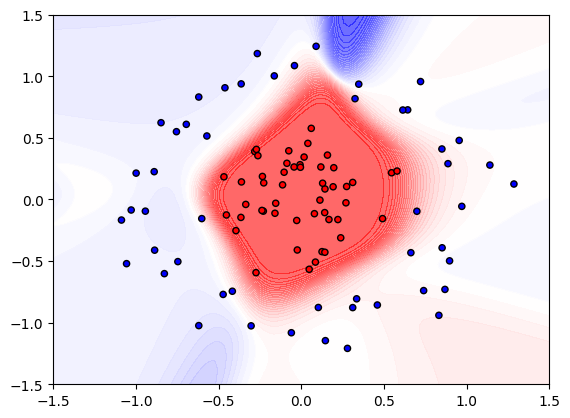

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# grid of points
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
zz = np.zeros_like(xx)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i, j] = circleMLP([xx[i, j], yy[i, j]]).data

plt.contourf(xx, yy, zz, levels=50, cmap='bwr', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr', s=20, edgecolors='k')
plt.show()


Text(0.5, 1.0, 'make_circles')

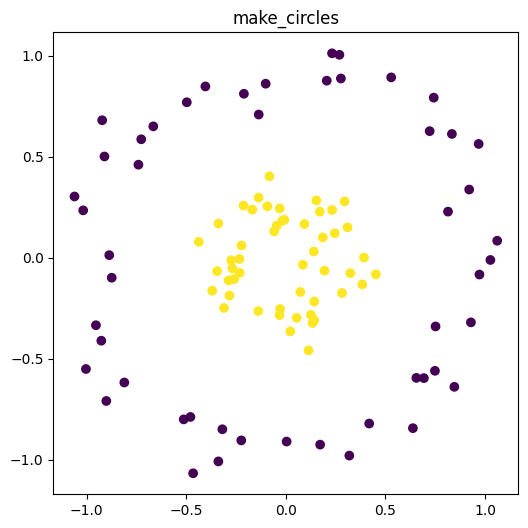

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 6))
X, Y = make_circles(noise=0.1, factor=0.3, random_state=1)
ax1.scatter(X[:, 0], X[:, 1], c=Y)
ax1.set_title("make_circles")

In [24]:
circleMLP = MLP(2, [5, 5, 1])

for k in range(1500):
    predicted_y = [circleMLP(x) for x in X]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(Y, predicted_y))

    for p in circleMLP.parameters():
        p.grad = 0
    loss.backward()

    
    for p in circleMLP.parameters():
        p.data += -0.01 * p.grad
    if k % 50 == 0:
        print (k, loss.data)

0 171.57272025992995
50 15.009996765963702
100 6.123289652555483
150 4.579152942784524
200 2.745450922907105
250 1.6529206227347304
300 1.2006160685085236
350 1.0090909416043283
400 0.9113939335370007
450 0.848233817759396
500 0.8023837926532401
550 0.7685267612920864
600 0.7435131014990257
650 0.7245705290642358
700 0.7090978950755257
750 0.6945733642414927
800 0.6785389806610221
850 0.6587883153210529
900 0.633778199750837
950 0.603084120858683
1000 0.5675659352530468
1050 0.529045134961889
1100 0.4896674649002839
1150 0.45132557174012783
1200 0.4153670114547895
1250 0.38256932223645895
1300 0.35325747681972386
1350 0.32745746689142874
1400 0.3050312056283187
1450 0.2857759194588205


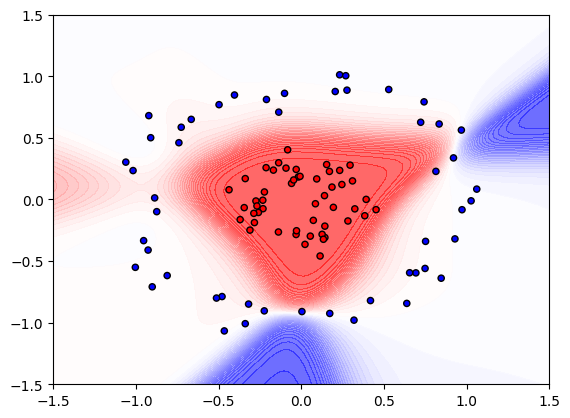

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# grid of points
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
zz = np.zeros_like(xx)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i, j] = circleMLP([xx[i, j], yy[i, j]]).data

plt.contourf(xx, yy, zz, levels=50, cmap='bwr', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr', s=20, edgecolors='k')
plt.show()

In [26]:
testpoint = [-1, -0.5]
output = circleMLP(testpoint)
print(output.data)

0.000890481806126181
